In [41]:
# -*- coding: utf-8 -*-
import libdtw as lib
import pickle
import numpy as np
from sksurv.linear_model import CoxPHSurvivalAnalysis
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from seaborn import kdeplot
import pymc3

data = lib.load_data(100)

D = lib.Dtw(data)

with open('dtwObjOptWeights16AllFeats.pickle', 'rb') as f:
    D_weights = pickle.load(f)
D.data['feat_weights'] = D_weights

step_pattern = 'symmetricP2'

In [77]:
data_set = D.generate_train_set(500, step_pattern, n_jobs = -1)
data_set.drop(columns = ['step_pattern'])

def build_structured_array(data_set):
    output = list()
    for idx, row in data_set.iterrows():
        survival_time = row['true_length'] - row['length']
        output.append((True, survival_time))
    res = np.array(output, dtype = [('status', bool), ('time_remaining', 'f8')])
    return res

data_y = build_structured_array(data_set)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.3min finished


In [79]:
for idx, row in data_set.iterrows():
    _id = row['query_id']
    batch = D.data['queries'][_id]
    length = row['length']
    for pv in batch:
        data_set.at[idx, pv['name']] = pv['values'][length - 1]
        
corr_matrix = data_set.corr().abs()
corr_matrix.fillna(1, inplace = True)
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
data_set.drop(columns = to_drop, inplace = True)
print(data_set.shape, '\n', data_set.columns)

(500, 13) 
 Index(['DTW_distance', 'length', 'query_id', 'step_pattern', 'ba_FQK6C3k2v6Z',
       'ba_FQ2Qyx', 'ba_FQADMQfb0z', 'ba_FQYXdr6Q0', 'ba_FQNOJG',
       'ba_FQnZKYLSO02xLf', 'ba_FQ68FvvUHzgUeA', 'ba_FQfXW5EZxRg3',
       'ba_FQPDzN'],
      dtype='object')


In [89]:
scale_dataset = MinMaxScaler()


ValueError: could not convert string to float: 'symmetricP2'

In [120]:
data_set_surv = data_set.drop(columns=['query_id', 'step_pattern'])

In [113]:
query_id = '5260'
true_length = len(data[query_id][0]['values'])

In [114]:
online = D.generate_train_set(step_pattern=step_pattern, query_id=query_id, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:  5.4min finished


In [115]:
for idx, row in online.iterrows():
    _id = row['query_id']
    batch = D.data['queries'][_id]
    length = row['length']
    for pv in batch:
        online.at[idx, pv['name']] = pv['values'][length - 1]

In [121]:
online_surv = online.loc[:, data_set_surv.columns]
data_set_surv = pd.DataFrame(scale_dataset.fit_transform(data_set_surv), columns=data_set_surv.columns)
online_surv = pd.DataFrame(scale_dataset.transform(online_surv), columns=data_set_surv.columns)
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_set_surv, data_y)

[ -1.27988857 -10.17500574   0.07552403   0.21039655   0.51050771
  -0.54129923  -0.31738736   0.46493691   0.62996944   0.35759347
   0.20800867]
[ 0.99452445 -4.77520102  0.08097863  0.14999939  0.65485296 -0.18094982
 -0.6171595   0.34177654  0.84733891 -0.70203093  0.24838024]
[ 0.46896061 -1.92207513  0.02849105 -0.0029764   0.12546808  0.12690179
 -0.25007822 -0.06110352  0.36368482 -0.13583118  0.04126914]
[ 0.06487791 -0.19011082  0.00527132  0.00170986  0.01400983  0.01567552
 -0.02942842 -0.00451733  0.03747644 -0.02094818  0.00130379]
[ 8.94989859e-04 -1.67907694e-03  5.37013761e-05  1.13390986e-05
  9.23456601e-05  2.15541246e-04 -2.83936228e-04 -1.79577617e-04
  3.44693632e-04 -1.51858851e-04  3.22399852e-06]
[ 1.45998937e-07 -1.38284073e-07  5.86852200e-09  8.34315123e-10
  5.70621482e-09  2.34888827e-08 -2.40307438e-08 -3.76888143e-08
  3.23528769e-08 -1.42690806e-08 -2.61062012e-10]


CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [122]:
online_surv.head()

,DTW_distance,length,ba_FQK6C3k2v6Z,ba_FQ2Qyx,ba_FQADMQfb0z,ba_FQYXdr6Q0,ba_FQNOJG,ba_FQnZKYLSO02xLf,ba_FQ68FvvUHzgUeA,ba_FQfXW5EZxRg3,ba_FQPDzN
0,0.321529,0.000000,0.999906,0.000089,0.202618,0.239465,0.002316,0.001669,0.896567,0.000219,0.008889
1,0.739820,0.002174,0.999906,0.000089,0.202618,0.239465,0.002316,0.001669,0.896567,0.000219,0.008889
2,0.797310,0.004348,0.999906,0.000089,0.202618,0.239465,0.002316,0.001669,0.896567,0.000219,0.008889
3,0.729169,0.006522,0.999906,0.000089,0.202618,0.239465,0.002316,0.001669,0.896567,0.000219,0.008889
4,0.789939,0.008696,0.999906,0.000089,0.202618,0.239465,0.002316,0.001669,0.896567,0.000219,0.008889


In [ ]:
import time
from IPython.display import clear_output

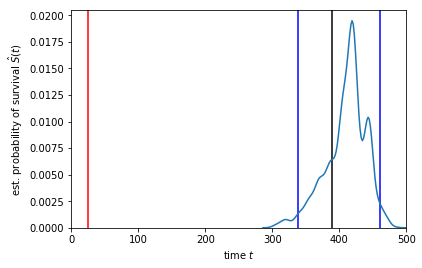

KeyboardInterrupt: 

In [123]:
for i in online_surv.index[::5]:
    
    row = online_surv.loc[i]    
    pred_surv = estimator.predict_survival_function(row)
    x = np.array(pred_surv[0].x) + i+1 
    y_weight = np.gradient(1 - pred_surv[0].y, x)
    scaler = MinMaxScaler((0, 100))
    y = np.floor(scaler.fit_transform(y_weight.reshape(-1, 1)).ravel())
    x_data = list()
    for j, n in zip(x, y):
        for k in np.arange(n):
            x_data.append(j)
    low, high = np.quantile(x_data, [.025, .975])
    clear_output()
    kdeplot(x_data)
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.vlines(true_length, 0, 1)
    plt.vlines(low, 0, 1, color = "b")
    plt.vlines(high, 0, 1, color = "b")
    plt.vlines(i, 0, 1, color = "r")
    plt.xlim((0, 500))
    plt.show()

    time.sleep(2)

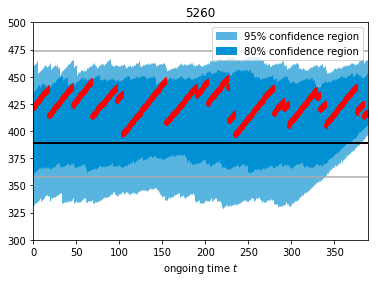

In [124]:
from scipy import stats
for i in online_surv.index:
    
    row = online_surv.loc[i]    
    pred_surv = estimator.predict_survival_function(row)
    x = np.array(pred_surv[0].x) + i+1 
    y_weight = np.gradient(1 - pred_surv[0].y, x)
    scaler = MinMaxScaler((0, 100))
    y = np.floor(scaler.fit_transform(y_weight.reshape(-1, 1)).ravel())
    x_data = list()
    for j, n in zip(x, y):
        for k in np.arange(n):
            x_data.append(j)
    low95, high95 = np.quantile(x_data, [.025, .975])
    low80, high80 = np.quantile(x_data, [.1, .9])
    pred = stats.mode(x_data)[0]
    #clear_output()
    #kdeplot(x_data)
    plt.fill_between([i], low95, high95, color = '#59b5e0')
    plt.fill_between([i], low80, high80, color = '#0090d3')
    plt.hlines(y=true_length, xmin=0,xmax=true_length,color='#000000')
    plt.xlabel("ongoing time $t$")
    plt.legend(labels = ['95% confidence region', '80% confidence region'])
    plt.scatter(i, pred, color = 'r')
    #plt.vlines(true_length, 0, 1)
    #plt.vlines(low, 0, 1, color = "b")
    #plt.vlines(high, 0, 1, color = "b")
    #plt.vlines(i, 0, 1, color = "r")
    plt.ylim((300,500))
    plt.xlim((0, true_length))
    
plt.hlines(y=true_length, xmin=0,xmax=true_length,color='#000000')
plt.hlines(y=358, xmin=0,xmax=true_length,color='#a9acad')
plt.hlines(y=474, xmin=0,xmax=true_length,color='#a9acad')

plt.title(query_id)
plt.show()

   # time.sleep(2)

In [110]:
pred[0]

array([421.])